In [1]:
import sys
sys.path.insert(0,'../../../ece219-project4')

from project4.utils.DataIO import DataIO
io = DataIO("../data/cache")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Silences warnings from sklearn
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
from project4.utils.WineDataset import *
from project4.utils.TrainingHelper import TrainingHelper

wine_data = WineDataset()

In [4]:
one_hot_encode_categorical(wine_data)

In [5]:
cols = list(wine_data.data.columns)

In [6]:
cat_cols = ['red', 'white']
target_col = ['quality']
num_cols = [col for col in cols if col not in cat_cols + target_col]

In [7]:
from project4.utils.WinePreprocessing import WinePreprocessing
processed_data = WinePreprocessing(wine_data, num_cols, cat_cols, target_col, io, stratify_col='red', cache_name="processed_data")

In [8]:
from ydata_profiling import ProfileReport
profile = ProfileReport(wine_data.og_data, title="Profiling Report")

In [9]:
# profile.to_notebook_iframe()

In [10]:
wine_data.data

,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,red,white
0,5,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,1.0,0.0
1,5,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,1.0,0.0
2,5,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,1.0,0.0
3,6,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,1.0,0.0
4,5,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,0.0,1.0
6493,5,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,0.0,1.0
6494,6,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,0.0,1.0
6495,7,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,0.0,1.0


# Question 1.1

In [11]:
heatmap_data = []
for col1 in cols:
    col1_info = []
    for col2 in cols:
        pearsonr = wine_data.data[col1].corr(wine_data.data[col2], method='pearson')
        col1_info.append(pearsonr)
    heatmap_data.append(col1_info)
heatmap_df = pd.DataFrame(heatmap_data, index=cols, columns=cols)

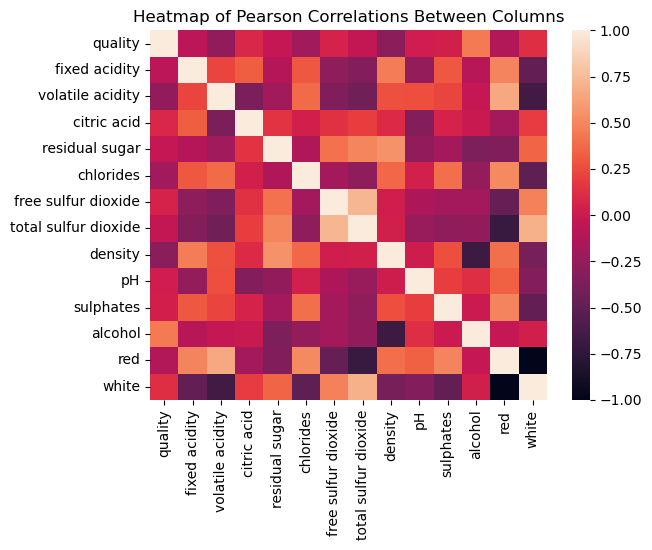

In [12]:
sns.heatmap(heatmap_df)
plt.title("Heatmap of Pearson Correlations Between Columns")
plt.show()

The heatmap helps us see how features correspond to each other. The middle of the map shows us that free sulfur dioxide and total sulfur dioxide are very correlated, which could mean that we could drop one of these features and not see a large impact on our algorithms. We also see that in the red and white columns, many of the features are highly correlated (either negatively or positively) to the type of wine. As we will see in our box plots in Question 1.3 later, the types have very similar quality distributions which might mean that we can remove the type features as the information is encoded into the chemical properties measured. One thing to note is that the most correlated feature to the quality variable is the alcohol content of the wine. 

# Question 1.2

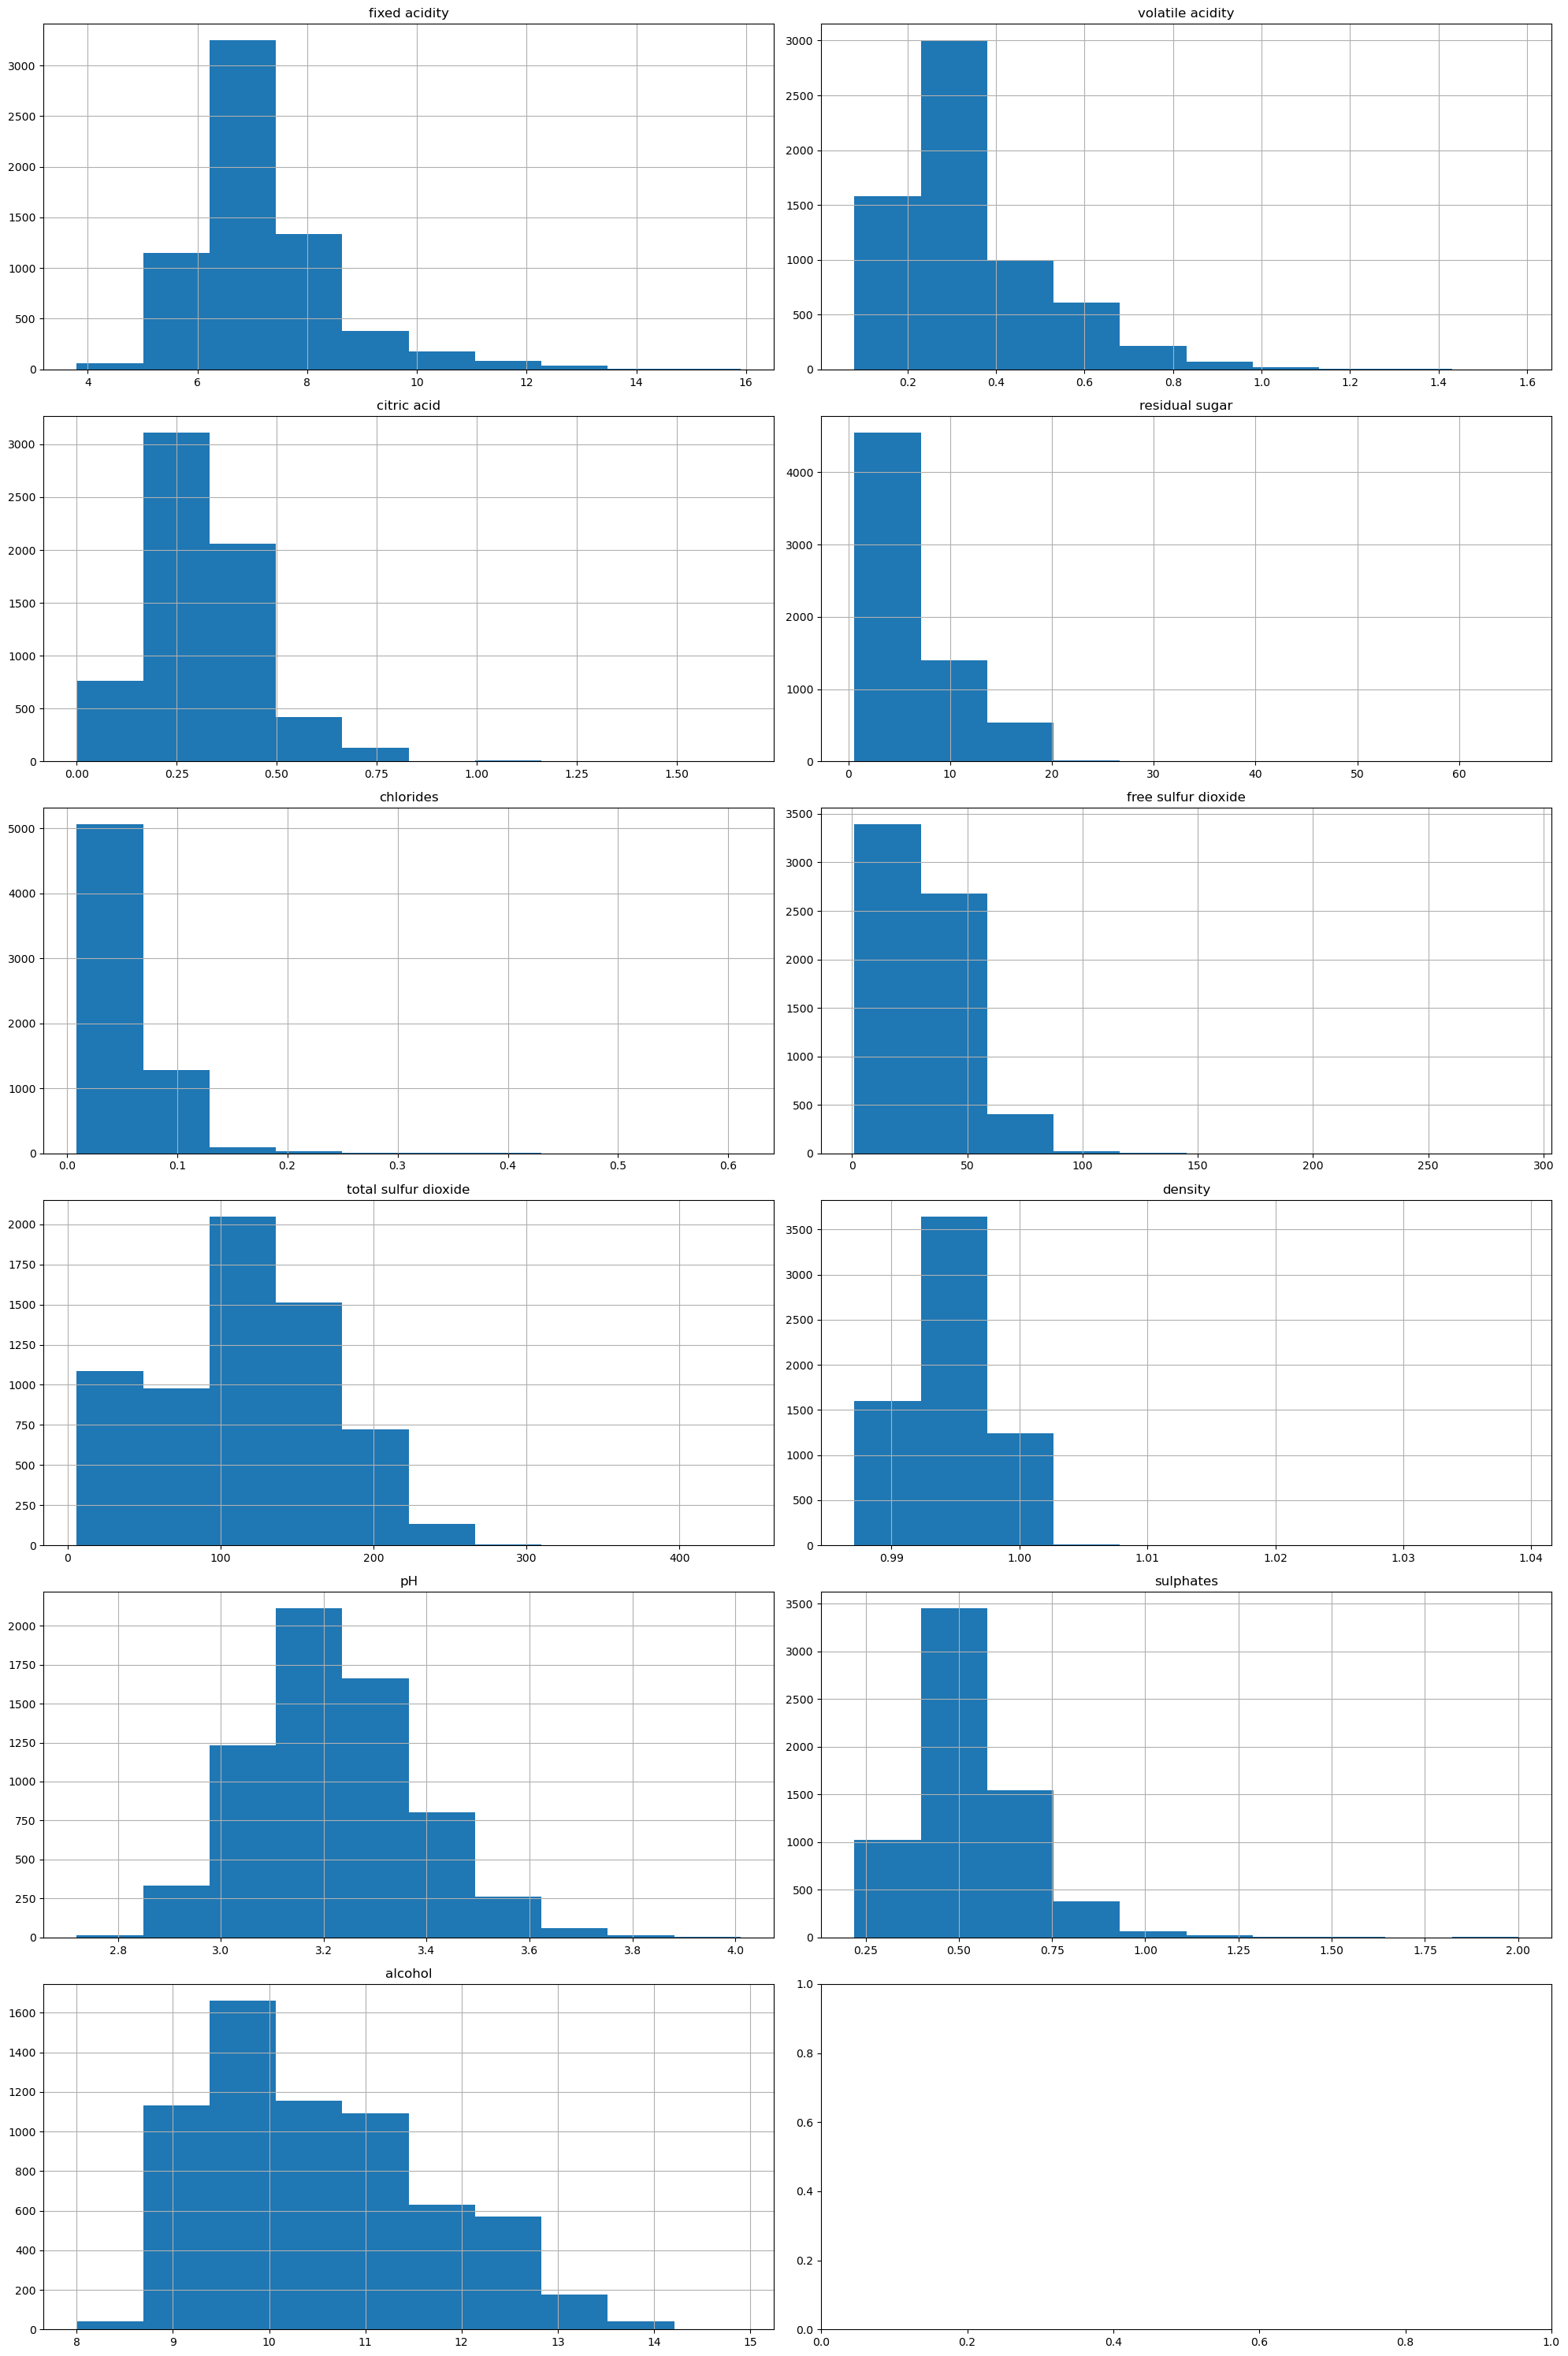

In [13]:
fig, ax = plt.subplots(len(num_cols)//2 + 1, 2)
for i in range(len(num_cols)):
    axis = ax[i//2][i%2]
    col = num_cols[i]
    wine_data.data.hist(col, ax=axis)
fig.set_figwidth(20)
fig.set_figheight(30)
fig.tight_layout()
fig.show()

The y-axis on all of these histograms is the number of occurrences of that specific bin. The x-axis is labeled above the graph. A few of these graphs are skewed to the right such as acidity but none of them are so skewed to required preprocessing. If this was required then a transformation can be applied to each feature in order to normalize it. One of the most popular techniques to do this with is log-scaling. 

# Question 1.3

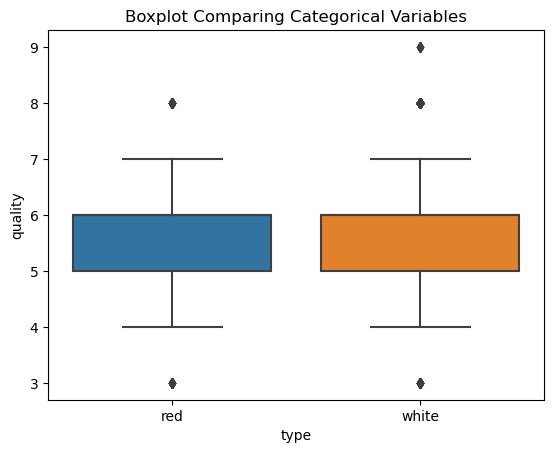

In [14]:
%matplotlib inline
fig, ax = plt.subplots(1, 1)
sns.boxplot(x = "type", y = "quality", data = wine_data.og_data, ax=ax)
ax.set_title("Boxplot Comparing Categorical Variables")
fig.show()

The only categorical variable in this dataset is the type (or color) of wine. The boxplot above is implying that the statistics for the whole dataset are about the same regardless of the type of wine. There are a few outliers in this dataset, depending on the amount of wines at these outlier points it may be worth removing them from our dataset so that our algorithms can not worry about fitting to them. 

# Question 1.4

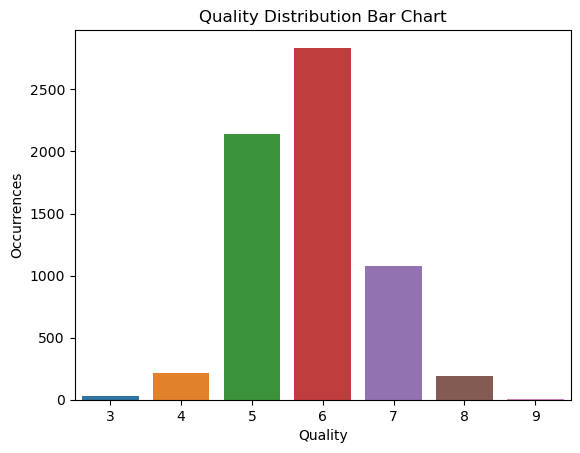

In [15]:
unique, counts = np.unique(wine_data.data['quality'], return_counts=True)
sns.barplot(x=unique, y=counts)
plt.title("Quality Distribution Bar Chart")
plt.xlabel("Quality")
plt.ylabel("Occurrences")
plt.show()

# Question 2.1 & 2.2

Note that in our code we stratify based on the color of the wine. Even though in our analysis we see not much dependence on the color of wine to the quality, the dataset is highly unbalanced and we would like to ensure that our testing set accurately represents the whole dataset. Some of the other parameters are highly reliant on the type of wine as can be seen in our heatmap so we want to ensure our algorithm is exposed to the full range of variables that are in the dataset and stratifying helps us achieve that. Later in the project we do not necessarily stratify our cross validation splits because in feature selection often the color characteristics are culled out. This is no matter, with 10 folds, it is highly unlikely that each fold will be so unbalanced and we take the best option.

Please see WinePreprocessing for the code on standardizing and feature selection. On a mathematical level, feature selection is removing information from the dataset so the accuracy of the model should suffer with ideal models. In practice however, certain features only serve to confuse models rather than help them, or provide no useful information if they are a linear combination of other features. We should expect to see a small decrease in the test RMSE using the reduced feature set across most model types. This is usually done for the benefit of reducing computational time. Some model types stand to benefit more than others. Smaller models that have trouble dealing with high dimensional data (such as clustering or simple linear models) feature selection helps them perform better. For more complicated models, feature selection can help reduce the curse of dimensionality which can cause serious overfitting in complex models. Extremely complicated models like deep learning neural networks can actually learn the feature selection process themselves in the early layers and it is often best to just feed all of the data into them. As such feature selection and its benefits are highly dependent on the end model you plan to use and what concerns you are trying to address.

In [16]:
sorted(processed_data.mi_scores())

[(0.003906622205269272, 'pH'),
 (0.010565924106434421, 'red'),
 (0.010565924106434421, 'white'),
 (0.02265923167267747, 'fixed acidity'),
 (0.032600532220745215, 'sulphates'),
 (0.0412193195855286, 'total sulfur dioxide'),
 (0.04238056468229079, 'citric acid'),
 (0.05148672047309244, 'chlorides'),
 (0.05187968018515665, 'free sulfur dioxide'),
 (0.06489547261569673, 'volatile acidity'),
 (0.07023899061893868, 'residual sugar'),
 (0.15135424583677892, 'density'),
 (0.15872843216878163, 'alcohol')]

This aligns with what we see in our heatmap of Pearson coefficients, alcohol having the highest MI score and the color the wine being one of the lowest. The two lowest features is pH and second place is tied between red and white (which makes sense because they have the same information). All three of these features are removed in our process leaving us with 10 total features in the reduced set. 

In [17]:
processed_data.data['metadata']['features']['reduced']

array(['fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'sulphates', 'alcohol'],
      dtype=object)

# Question 4.1

From the sklearn documentation: "LinearRegression fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation." The objective function here is the sum of the squares of the residuals.

In [21]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
lin_reg = TrainingHelper(LinearRegression(), processed_data, 'scaled')
lin_est, lin_results, lin_rmse = lin_reg.cv()

In [22]:
print(lin_est.coef_)
print(f"Test RMSE: {lin_rmse}")

[[ 0.11650686 -0.23107689 -0.01478029  0.29804877 -0.02169336  0.07137022
  -0.059812   -0.33596708  0.07714504  0.11037863  0.24993555  0.07740438
  -0.07740438]]
Test RMSE: 0.7211833628832407


In [23]:
ridge_space = {
    "alpha": (1e-4, 1e4, 'log-uniform')
}
lin_ridge = TrainingHelper(Ridge(), processed_data, 'scaled')
ridge_est, ridge_results, ridge_rmse = lin_ridge.bayes(ridge_space, 32)

In [24]:
print(ridge_est.coef_)
print(f"Test RMSE: {ridge_rmse}")

[[ 0.10958473 -0.23660545 -0.01533314  0.28682594 -0.02264703  0.07320831
  -0.062752   -0.29093733  0.07569908  0.10933797  0.27629901  0.07063656
  -0.07063656]]
Test RMSE: 0.7213109462594749


In [25]:
lasso_space = {
    "alpha": (1e-4, 1e4, 'log-uniform')
}
lin_lasso = TrainingHelper(Lasso(), processed_data, 'scaled')
lasso_est, lasso_results, lasso_rmse = lin_lasso.bayes(lasso_space, 32)

In [26]:
print(lasso_est.coef_)
print(f"Test RMSE: {lasso_rmse}")

[ 0.10983201 -0.23655182 -0.01490489  0.28826324 -0.02179684  0.07206459
 -0.0615666  -0.29287697  0.07593404  0.10916998  0.27601211  0.14205032
 -0.        ]
Test RMSE: 0.7213732046040701


The above experiments show the difference between non-regularized, ridge, and lasso regularization linear regression. Ridge regularization drive the magnitudes of the weight coefficients to be smaller. The difference here is very small as the weights found by normal linear regression are already very small, but certain weights like the 0.33 are driven down in the ridge regression. Lasso regularization tends to drive certain parameters to 0. In this case one of the coefficients does go all the way to 0. 

# Question 4.2
Technically the learned classifier wit the best performance on the test set is the normal linear regression, but all three test RMSEs are very close to each other. With error differences that small it does not really matter which classifier we go with but we decided on the regular linear regression. The ridge and lasso regularizations found their optimal parameters through a Bayes search from skopt varying the alpha parameter on a logarithmic scale.

In [28]:
print(ridge_est.alpha)
print(lasso_est.alpha)

11.545681587879768
0.0004226015479981204


# Question 4.3

In [29]:
ridge_non_scaled = TrainingHelper(Ridge(alpha=ridge_est.alpha), processed_data, 'original')
ridge_reduced = TrainingHelper(Ridge(alpha=ridge_est.alpha), processed_data, 'reduced')
_, _, res = ridge_non_scaled.cv()
print(f"RMSE on Test Set (Ridge trained on original features): {res}")
_, _, res = ridge_reduced.cv()
print(f"RMSE on Test Set (Ridge trained on reduced features): {res}")

RMSE on Test Set (Ridge trained on original features): 0.7257958532049933
RMSE on Test Set (Ridge trained on reduced features): 0.7253208141816923


Here we run an experiment with a ridge classifier to see if scaling and feature selection makes a difference. We can see that the overall RMSE on the test set is higher in both cases than when running on just the scaled data. This is because scaling has an advantage over unscaled data, but then reducing the feature set removes some of the information making its RMSE higher as well.

# Question 4.4
The p-values returned by these libraries correspond to the p-value in statistics. This value signifies if the null-hypothesis can be rejected or not. The null hypothesis in this scenario is that the coefficient corresponding to that p-value is 0. If the p-value is low, this hypothesis can be rejected and it is likely that coefficient and corresponding feature is correlated in some way (linearly or otherwise) to the target variable.

# Question 5.1

In [30]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
polynomial_pipe = Pipeline(steps=[
    ('poly', PolynomialFeatures()),
    ('regression', Ridge())
])
poly_regress = TrainingHelper(polynomial_pipe, processed_data, 'reduced')
poly_space = {
    "poly__degree": (2,6),
    "regression__alpha": (1e-4, 1e4, 'log-uniform')
}
poly_est, poly_results, poly_rmse = poly_regress.bayes(poly_space, n_iter=64)

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=4.41878e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.35814e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=5.37981e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.22475e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrit

In [56]:
poly_feature_names = poly_est['poly'].get_feature_names_out(input_features=processed_data.data['metadata']['features']['reduced'])
coefficients = [np.abs(i) for i in poly_est['regression'].coef_[0]]
combined = list(zip(coefficients, poly_feature_names))
top5 = sorted(combined, reverse=True)[:5]
top5

[(0.2565010079948814, 'alcohol'),
 (0.18673711817331265, 'volatile acidity'),
 (0.10265601389244569, 'residual sugar'),
 (0.09904857734842928, 'free sulfur dioxide'),
 (0.09763316106480474, 'sulphates')]

Our top 5 features with the highest (in magnitude) coefficients in the resulting model are all terms of degree 1. They are also mostly the features that had the most correlation with the target variable in the previous sections. The higher terms are regulated by the ridge regression to avoid overfitting and since these terms are the ones more liable to cause overfitting are also most affected by the regularization.

# Question 5.2

In [41]:
poly_rmse

0.7090426020512389

In [32]:
poly_est.get_params()

{'memory': None,
 'steps': [('poly', PolynomialFeatures()),
  ('regression', Ridge(alpha=710.2161994888754))],
 'verbose': False,
 'poly': PolynomialFeatures(),
 'regression': Ridge(alpha=710.2161994888754),
 'poly__degree': 2,
 'poly__include_bias': True,
 'poly__interaction_only': False,
 'poly__order': 'C',
 'regression__alpha': 710.2161994888754,
 'regression__copy_X': True,
 'regression__fit_intercept': True,
 'regression__max_iter': None,
 'regression__positive': False,
 'regression__random_state': None,
 'regression__solver': 'auto',
 'regression__tol': 0.0001}

In [39]:
poly_results[poly_results['param_poly__degree'] == 5][['param_regression__alpha', 'split0_test_score', 'split0_train_score']]

,param_regression__alpha,split0_test_score,split0_train_score
5,8507.313383,-1.014094,-0.646530
14,58.493593,-3.820611,-0.504047
46,10000.0,-0.991382,-0.651718
54,0.0001,-103.667984,-0.314992


We use the reduced features when doing polynomial regression to help us save on time. Adding another feature that does not contribute much can add many more useless features when the degree of the polynomial is high. Our best result was with a degree 2 polynomial. We did a Bayes search using skopt over the degree of the polynomial as well as the alpha regularization parameter. We can see from our results that with a high degree (degree 5) our error on the training data is lower than we have seen so far, but when the ridge regularization parameter is small the model heavily overfits to the training data and the error on the validation data is incredibly high. With a higher regularization parameter, this tempers the overfitting but not enough to beat out not having those features in the first place. The RMSE on the test data with degree 2 and alpha ~710 is better than any of our previous classifiers.

# Question 6.1

In [43]:
from sklearn.neural_network import MLPRegressor

mlp_sklearn = TrainingHelper(MLPRegressor(), processed_data, 'scaled')
mlp_grid = {
    'activation': ['relu', 'identity'],
    'alpha': [1e-5, 1e-2, 1e1],
    'hidden_layer_sizes': [[32], [128], [32, 64, 32], [64, 128, 64]]
}
mlp_est, mlp_results, mlp_rmse = mlp_sklearn.grid(mlp_grid)

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/

In [44]:
mlp_est.get_params()

{'activation': 'relu',
 'alpha': 1e-05,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': [128],
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

The best hyper parameter set found was with ReLU activation, a low alpha of 10^(-5) and a wide but shallow network with 128 nodes in 1 hidden layer.

In [45]:
mlp_rmse

0.6748978996913244

# Question 6.2
The RMSE found on the test set was better than both of our linear regression methods but not by very much. MLPs are much more complex models than general linear regression so it is no surprise that the accuracy is better and as long as we include some regularization the generalization gap stays small.

# Question 6.3
We chose ReLU as the activation function. ReLU is an industry standard activation with an easy to compute gradient that keeps gradients from vanishing. We compared this to no activation. ReLU won out because without an activation function like ReLU the MLP cannot model any nonlinear behavior. Without an activation function MLPs are no better than normal linear regression.

# Question 6.4
When creating deep networks, there are two main concerns that can occur with deep networks. Deep networks are complex and can very easily overfit without any regularization. This is why weight decay and dropout layers are so important with deep learning. Also, as networks become deeper, when training there is a risk that gradient descent fails due to vanishing gradients. As gradients backpropagate throughout the layers, there is a risk that the gradients at the next layer become smaller, causing training to take a long time or becoming impossible in severe scenarios.

As a bonus (and for my own practice) we also implement the MLP in pytorch using dropout layers as weight regularization.

In [29]:
from torch import nn
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [40]:
from sklearn.base import BaseEstimator, RegressorMixin
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

learning_rate = 1e-3
batch_size = 64
epochs = 100

class BasicNN (nn.Module, BaseEstimator, RegressorMixin):
    def __init__(self) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.LazyLinear(64), nn.ReLU(), nn.Dropout(),
            nn.LazyLinear(128), nn.ReLU(), nn.Dropout(),
            nn.LazyLinear(64), nn.ReLU(), nn.Dropout(),
            nn.LazyLinear(1)
        )
        mse = nn.MSELoss()
        self.loss_fn = lambda y_hat, y: torch.sqrt(mse(y_hat, y))
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=learning_rate)

    def forward(self, x):
        res = self.model(x)
        return res
    
    def fit(self, X, y):
        self.model.train()
        train_dataset = TensorDataset(X, y)
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True)
        for t in tqdm(range(epochs)):
            self._train_loop(train_dataloader, self.loss_fn, self.optimizer)

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            test_dataset = TensorDataset(X)
            test_dataloader = DataLoader(test_dataset)
            predictions = np.zeros((X.shape[0]))
            for batch, x in enumerate(test_dataloader):
                pred = self.model(x[0])
                predictions[batch] = pred
        return predictions
    
    def score(self, X, y):
        self.model.eval()
        with torch.no_grad():
            test_dataset = TensorDataset(X, y)
            test_dataloader = DataLoader(test_dataset)
            loss = self._test_loop(test_dataloader, self.loss_fn)
        return loss
        
    
    def _train_loop(self, dataloader, loss_fn, optimizer):
        # Set the model to training mode - important for batch normalization and dropout layers
        # Unnecessary in this situation but added for best practices
        for batch, (X, y) in enumerate(dataloader):
            # Compute prediction and loss
            pred = self.model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

    def _test_loop(self, dataloader, loss_fn):
        # Set the model to evaluation mode - important for batch normalization and dropout layers
        # Unnecessary in this situation but added for best practices
        num_batches = len(dataloader)
        test_loss = 0

        # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
        # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
        with torch.no_grad():
            for X, y in dataloader:
                pred = self.model(X)
                test_loss += loss_fn(pred, y).item()

        test_loss /= num_batches
        return test_loss
        

In [41]:
from sklearn.model_selection import KFold
from torch.utils.data import TensorDataset, DataLoader
import torch
from tqdm import tqdm

kf = KFold(10)
scaled_training_data = processed_data.data['train']['features']['scaled']
training_target = processed_data.data['train']['target']
for kf_train, kf_val in kf.split(scaled_training_data, training_target):
    X_train_tensor = torch.Tensor(scaled_training_data[kf_train]).to(device)
    y_train_tensor = torch.Tensor(training_target[kf_train]).to(device)

    X_val_tensor = torch.Tensor(scaled_training_data[kf_val]).to(device)
    y_val_tensor = torch.Tensor(training_target[kf_val]).to(device)

    model = BasicNN().to(device)
    model.fit(X_train_tensor, y_train_tensor)
    epoch_train_loss = model.score(X_train_tensor, y_train_tensor)
    epoch_val_loss = model.score(X_val_tensor, y_val_tensor)
    print(f"Final Training loss: {epoch_train_loss}")
    print(f"Final Validation loss: {epoch_val_loss}")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:11<00:00,  8.93it/s]


Final Training loss: 0.6629321265735508
Final Validation loss: 0.7025353404191824


100%|██████████| 100/100 [00:11<00:00,  8.96it/s]


Final Training loss: 0.6676295222139063
Final Validation loss: 0.6578980519221379


100%|██████████| 100/100 [00:11<00:00,  8.84it/s]


Final Training loss: 0.7029302736518473
Final Validation loss: 0.705958930345682


100%|██████████| 100/100 [00:11<00:00,  8.74it/s]


Final Training loss: 0.6793469638428883
Final Validation loss: 0.6521066720669086


100%|██████████| 100/100 [00:11<00:00,  8.90it/s]


Final Training loss: 0.6591241640592962
Final Validation loss: 0.6719612020712632


100%|██████████| 100/100 [00:11<00:00,  8.93it/s]


Final Training loss: 0.6729523046214992
Final Validation loss: 0.6751788707879873


100%|██████████| 100/100 [00:11<00:00,  9.00it/s]


Final Training loss: 0.6980364946108841
Final Validation loss: 0.6813406962614793


100%|██████████| 100/100 [00:11<00:00,  8.85it/s]


Final Training loss: 0.6797778892843271
Final Validation loss: 0.7199337027665508


100%|██████████| 100/100 [00:11<00:00,  8.93it/s]


Final Training loss: 0.6862977870053948
Final Validation loss: 0.6617121687284554


100%|██████████| 100/100 [00:11<00:00,  8.96it/s]


Final Training loss: 0.6597357604584158
Final Validation loss: 0.6662674648453965


In [42]:
X_test_tensor = torch.Tensor(processed_data.data['test']['features']['scaled']).to(device)
y_test_tensor = torch.Tensor(processed_data.data['test']['target']).to(device)
model.score(X_test_tensor, y_test_tensor)

0.6619936675291795

# Question 7.1
The number of trees indicates how many individual trees are trained. The predictions of each tree are averaged together to provide one final value (simplification of the actual bagging technique used). Increasing the number of trees increases the complexity the model can fit to, which can make it more expressive and CAN cause generalization error (see Mark R. Segal (April 14 2004. "Machine Learning Benchmarks and Random Forest Regression.")) although not typically. Max features is the number of features that are considered when looking for the best split. By increasing this the tree has more choices at each node and can be more expressive. Max depth is the max number of decisions that can be made by each tree before it must give a prediction, and is the main regularization term. This stops the trees from analyzing the variables to death and forces them to give a best guess. Random forests are relatively protected against generalization error so this hyperparameter is not super important, and as we will see in the code ahead, the best estimator found has the highest max depth we allow and there is still no generalization error.

# Question 7.2
At each node a tree can make a linear decision. And then at each node more decisions are made. In a 2D feature space we can visualize this as several vertical and horizontal lines being drawn and the resulting spaces getting smaller and smaller and rectangles becoming more concise on the space that the tree is trying to section off. Each section receives a prediction and then the predictions of many trees are bagged together. So even though each node has a linear decision, after many of them run successively, and then this is done many times and combined the predictions can become quite refined.

# Question 7.3

In [62]:
from sklearn.ensemble import RandomForestRegressor

random_forest_grid =  {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 7, 9],
    "max_features": [1.0, 0.5, 0.25]
}
random_forest_trainer = TrainingHelper(RandomForestRegressor(), processed_data, 'scaled')
rf_est, rf_results, rf_rmse = random_forest_trainer.grid(random_forest_grid)


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y wa

In [63]:
rf_rmse

0.6603694363331131

In [64]:
rf_est

RandomForestRegressor(max_depth=9, max_features=0.5, n_estimators=200)

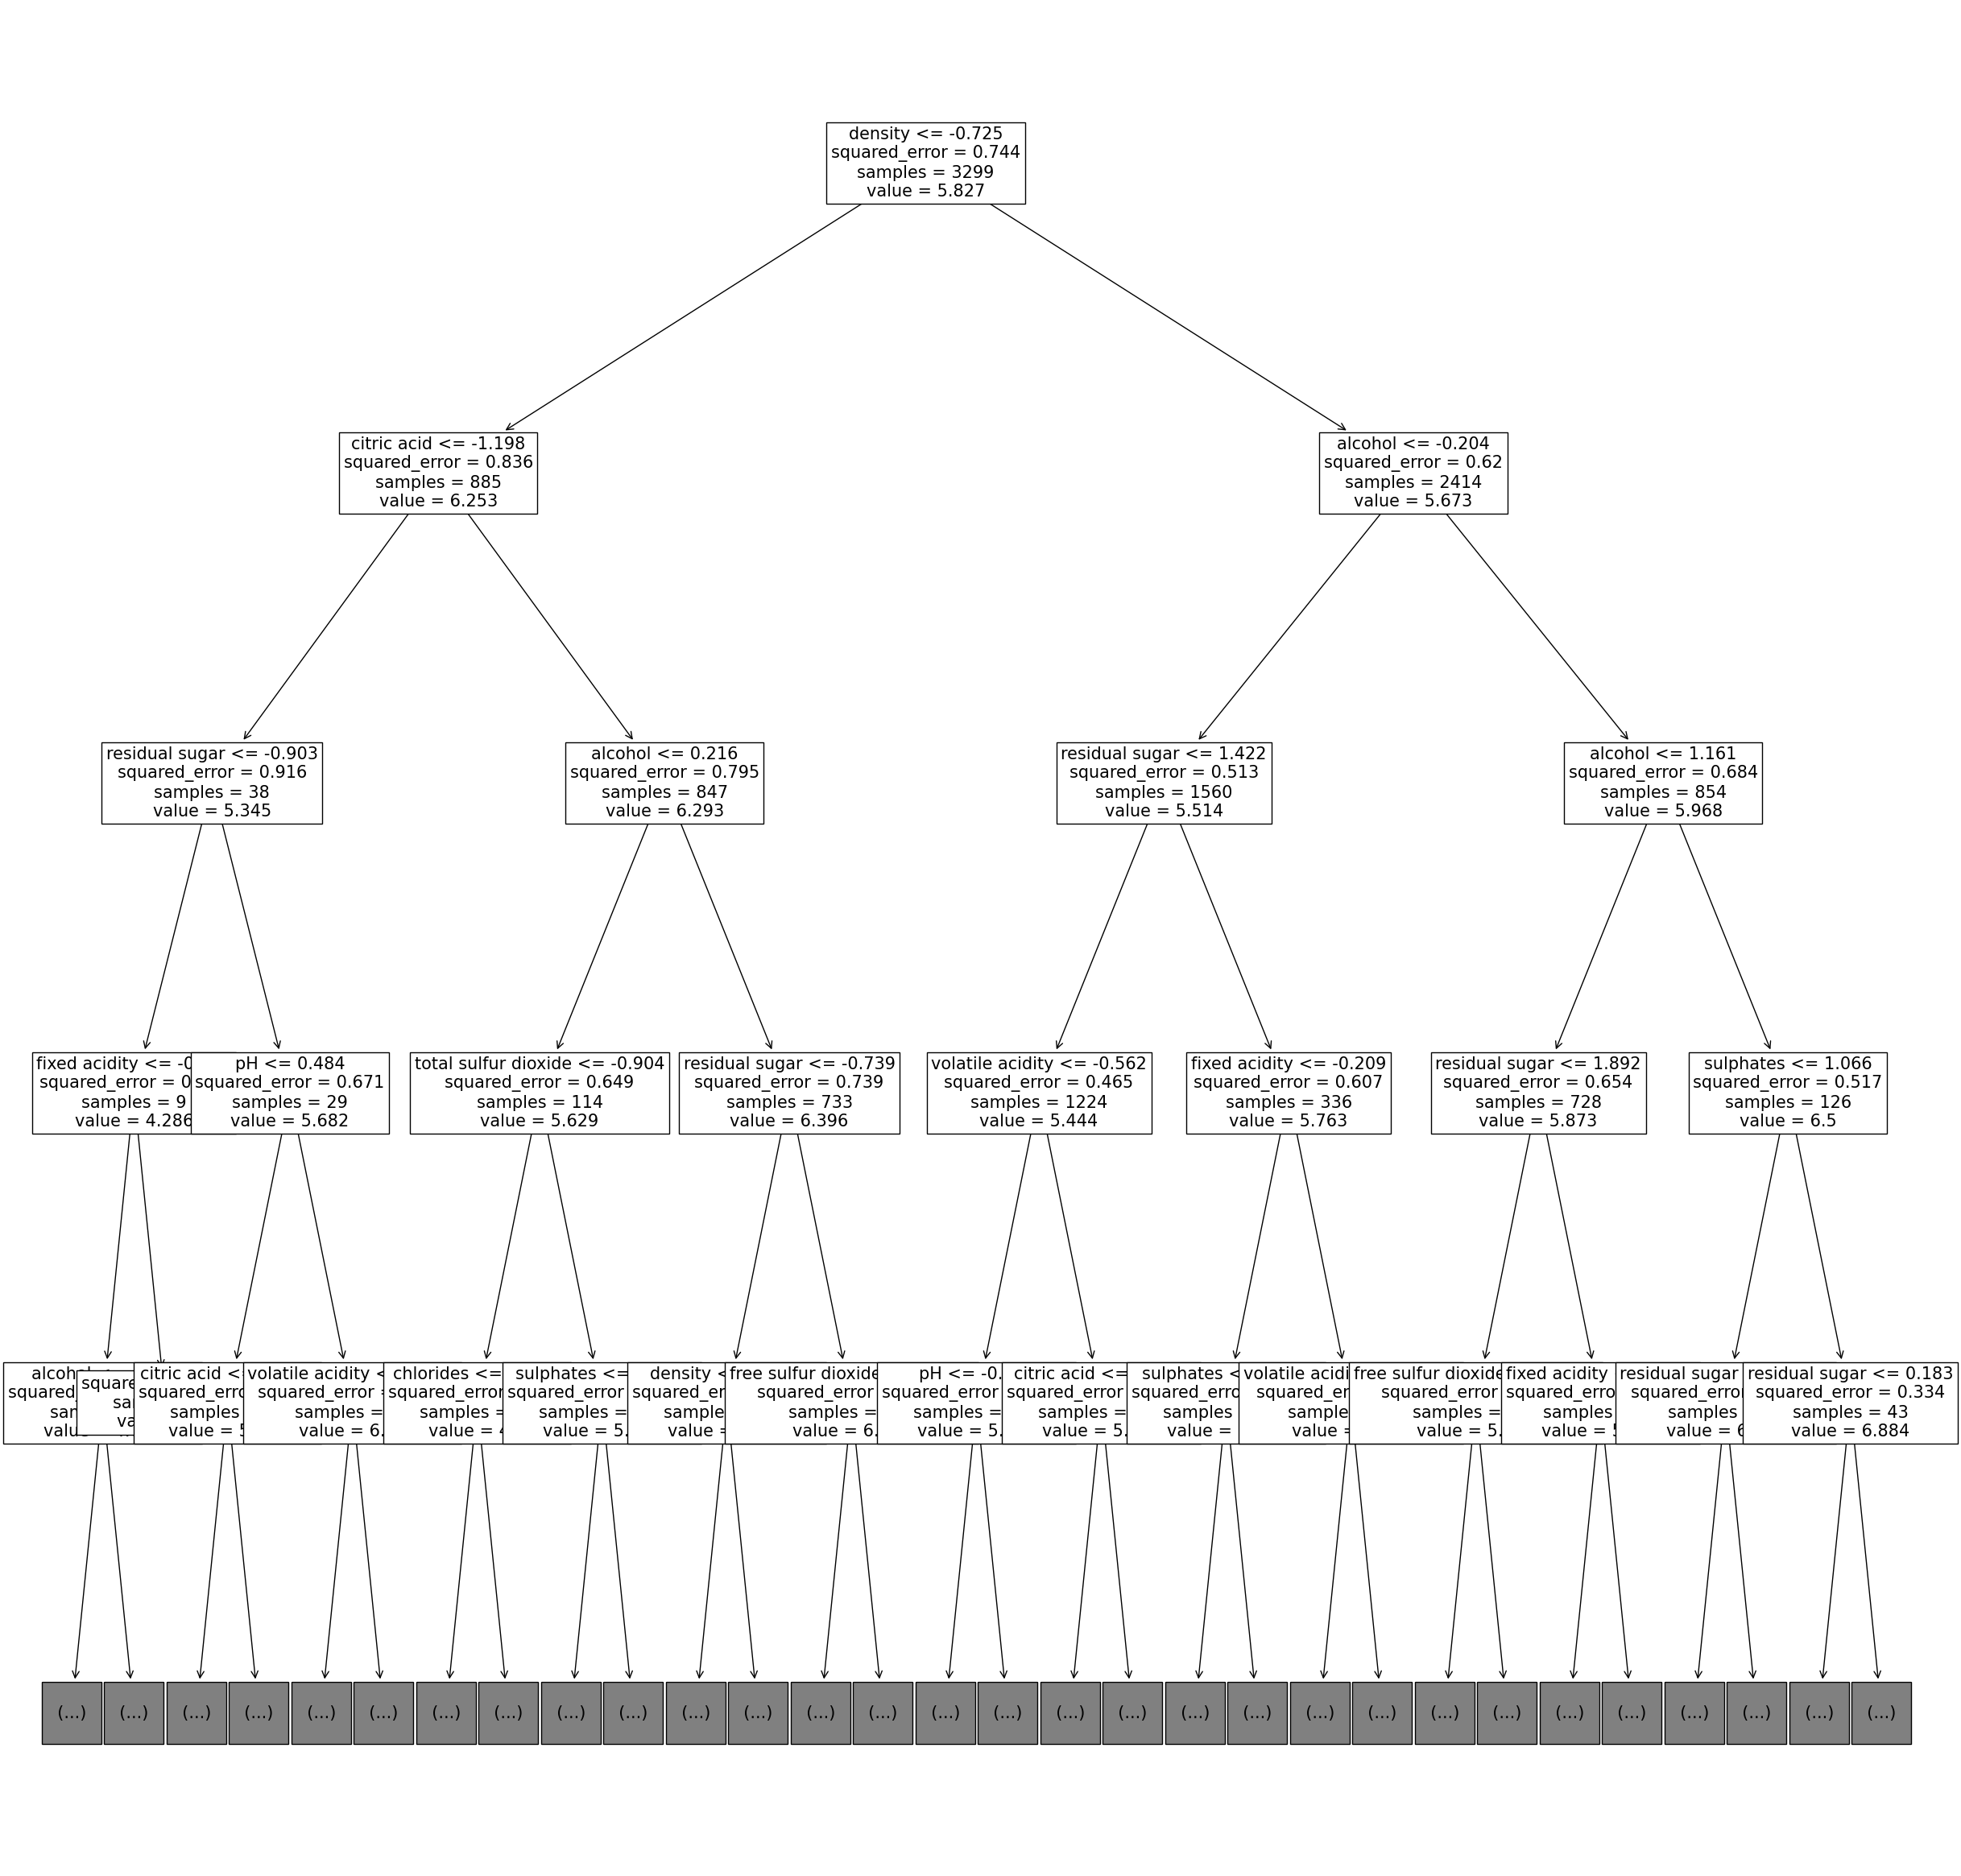

In [65]:
from sklearn.tree import plot_tree
import random
import matplotlib.pyplot as plt
num_estimators = len(rf_est.estimators_)
random_estimator = rf_est.estimators_[random.randint(0, num_estimators-1)]
fig, ax = plt.subplots(1, 1)
plot_tree(random_estimator, feature_names=processed_data.data['metadata']['features']['original'], max_depth=4, ax=ax, fontsize=15)
fig.set_figheight(30)
fig.set_figwidth(30)
fig.show()

In [66]:
sorted(list(zip(rf_est.feature_importances_, processed_data.data['metadata']['features']['original'])), reverse=True)

[(0.28095856738033065, 'alcohol'),
 (0.1373879244814295, 'volatile acidity'),
 (0.10176527410158112, 'density'),
 (0.08686739256947396, 'free sulfur dioxide'),
 (0.0652356740123675, 'chlorides'),
 (0.06266872392020223, 'residual sugar'),
 (0.061187963135127685, 'sulphates'),
 (0.05799321382771762, 'citric acid'),
 (0.05110336742671548, 'total sulfur dioxide'),
 (0.046443834413023216, 'pH'),
 (0.045382335002805495, 'fixed acidity'),
 (0.0018457929697614306, 'red'),
 (0.001159936759464109, 'white')]

The root node is split on density (this could change as the notebook gets rerun and random does its job). The root node would presumably be the most important feature for this specific tree. Most of the nodes are split on one of the more important features (shown in the cell above) which does align with what we found in the feature selection part of the project.

# Question 7.4

In [69]:
rf_est.set_params(oob_score=True)
oob_training = TrainingHelper(rf_est, processed_data, 'scaled')
refit_oob_rf, _, _ = oob_training.cv()

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y wa

In [72]:
oob_error = 1 - refit_oob_rf.oob_score_
oob_error

0.5873742847850201

The Out Of Bag (OOB) error is shown above after refitting the best random forest. Each tree is fit from a subsample of the dataset, and the OOB error helps measure the performance of the model when a data point of train set is then predicted using the trees that did not include that data point in their subset. As far as OOB errors go, our is relatively high, but the RMSE of our overall model on the test data is sufficient. The R2 score is another metric that can be used to determine the generalization score of the random forest with the data outside of the bootstrapped data. It is calculated as 1 - (sum of squares of residuals)/(total sum of squares). The R2 score tells us how much of the variance in the data is actually explained by our model.

# Question 8.1

The following space takes about 8 minutes on my machine although it is a pretty decent size so I figured I would not expand the search any further to ensure it runs in Google Colab in the time limit. The most important hyperparameter is the num_leaves. The more leaves the more complex each tree can be and the more accurate the model becomes. Rather than specify the depth (because we don't know what the num_leaves will be in that run) we reduce generalization error by changing the min_data_in_leaf hyperparameter. This helps us to avoid overfitting by giving each individual data point its own leaf. We also try out both of the boosting algorithms that lightgbm offers (for fun). The search space can be seen below. There are certainly many more parameters to play with but this space gives us a very good end result in comparison to the other models so we will stick with this.

In [80]:
import lightgbm as lgbm
from skopt.space import Integer, Real, Categorical

lgbm_helper = TrainingHelper(lgbm.LGBMRegressor(), processed_data, 'scaled')
lgbm_space = {
    "boosting_type": Categorical(['gbdt', 'dart']),
    "num_leaves": Integer(15, 127, 'uniform'),
    "min_data_in_leaf": Integer(1, 10, 'uniform')
}
lgbm_est, lgbm_results, lgbm_rmse = lgbm_helper.bayes(lgbm_space, n_iter=32)

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vecto

[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.814625
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info]

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1541
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.822536
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_s

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1543
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.813596
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_s

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.815519
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_s

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_lea

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vecto

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.816335
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_d

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.818687
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-th

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1543
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.813596


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.820009


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.815519


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vecto

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.816335


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.818687
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_le

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1543
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.813596
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_s

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.815519


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vecto

[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 4677, number of used featu

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vecto

[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1543
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.813596
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_s

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.815519
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_s

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vecto

[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.816335


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.818687


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1541
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.822536


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1543
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.813596


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.820009


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.815519
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_s

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_lea

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vecto

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.819970
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.827453
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.818687


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1541
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.822536
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, 

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1543
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.813596
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, 

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.815519


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vecto

[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.816335


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.818687
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_s

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1543
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.813596


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.820009
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_s

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.815519
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_s

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vecto

[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.816335


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.818687
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_s

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.820009


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.815519
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_s

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Info] Auto-choosing row-wise

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vecto

[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.816335


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.818687


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1541
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.822536
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_s

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.820009


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.815519
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_s

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing col-wise

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vecto

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.819970
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info]

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.818687


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1541
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.822536
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_s

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.820009


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.815519


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vecto

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.814625
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_s

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1541
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.822536


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1543
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.813596


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.820009


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 4678, number of used featu

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_lea

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vecto

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.816335


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-c

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1543
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.813596


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.820009


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.815519


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vecto

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Info] Auto-choosing col-wise

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.818687
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_s

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.820009


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.815519
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_s

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vecto

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.814625
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_s

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.818687
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_s

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1541
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.822536
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, 

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.820009


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.815519


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vecto

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Nu

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.818687


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1541
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.822536


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1543
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.813596


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.820009


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.815519


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vecto

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004167 seconds.
You can set `force_col_wise=true` to remov

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.818687


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1541
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.822536


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1543
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.813596


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.820009


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.815519


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vecto

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.816335


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.818687


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1541
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.822536


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1543
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.813596


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.820009


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.815519


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vecto

[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Info] Number of data points in the train set: 4677, number of used featu

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.818687


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1541
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.822536


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1543
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.813596
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_s

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.815519
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_le

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Info] Auto-choosing col-wise

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vecto

[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.816335


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.818687


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1541
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.822536


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1543
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.813596


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.820009


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.815519


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9

[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vecto

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.814625
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.818687


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1541
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.822536
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, 

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.820009


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.815519


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vecto

[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.814625
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_s

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1541
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.822536
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, t

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 4678, number of used featu

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vecto

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing wa

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.818687
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_s

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1543
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.813596


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.820009


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.815519


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vecto

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-c

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.818687


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1541
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.822536


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1543
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.813596


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.820009


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.815519


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vecto

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001882 seconds.
You can set `force_col_wise=true` to remov

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.818687


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1541

[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.822536
[LightGBM] [Warning] min_data_in_leaf is set=10, 

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.820009
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, 

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.815519
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, 

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vecto

[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.816335
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_s

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.818687
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_s

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.820009
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_s

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.815519
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vecto

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002999 seconds.
You can set `force_col_wise=true` to remove the overhead

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.818687


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1541
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.822536


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1543
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.813596


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.820009


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.815519


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vecto

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.816335


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.818687


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1541
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.822536


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1543
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.813596


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.820009


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.815519
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_s

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Info] Auto-choosing col-wise

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vecto

[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.816335


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.818687
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_s

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1543
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.813596


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.820009


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.815519
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_s

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vecto

[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.814625
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_le

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1541
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.822536
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.820009
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_s

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vecto

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of data points in the train set: 4677, number o

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.818687
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-t

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1543
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.813596


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.820009
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, 

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vecto

[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.816335


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.818687


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1541
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.822536


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1543
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.813596


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.820009


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.815519
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_s

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vecto

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from 

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.818687


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1541
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.822536


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1543
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.813596


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.820009


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 13
[LightGBM] [Info] Start training from score 5.815519


/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min

# Question 8.2

In [81]:
lgbm_est

LGBMRegressor(min_data_in_leaf=2, num_leaves=121)

The boosting type of this estimator is gbdt, not shown because it is the default value. The min_data_in_leaf was 2 and the num_leaves was 121. This could change if this notebook is rerun.

In [82]:
lgbm_rmse

0.6119376756442375

This is a great RMSE and beats out all previous models.

# Question 8.3

In [87]:
lgbm_results[lgbm_results["param_num_leaves"] > 65][['mean_fit_time', 'mean_train_score', 'mean_test_score']].median()

mean_fit_time       7.073152
mean_train_score   -0.215440
mean_test_score    -0.623016
dtype: float64

In [88]:
lgbm_results[lgbm_results["param_num_leaves"] < 65][['mean_fit_time', 'mean_train_score', 'mean_test_score']].median()

mean_fit_time       2.645424
mean_train_score   -0.752956
mean_test_score    -0.872156
dtype: float64

In [94]:
lgbm_results[lgbm_results["param_num_leaves"] > 100][['mean_fit_time', 'mean_train_score', 'mean_test_score', 'param_boosting_type', "param_num_leaves", "param_min_data_in_leaf"]]

,mean_fit_time,mean_train_score,mean_test_score,param_boosting_type,param_num_leaves,param_min_data_in_leaf
1,8.725429,-0.193613,-0.621112,gbdt,117,10
8,7.073152,-0.213548,-0.623057,gbdt,104,9
10,8.559970,-0.157576,-0.619095,gbdt,127,2
11,8.446417,-0.177231,-0.620453,gbdt,127,10
13,9.867270,-0.157798,-0.625288,gbdt,127,1
16,8.771169,-0.166681,-0.618029,gbdt,121,2
22,7.923360,-0.179405,-0.622558,gbdt,126,10
23,7.115943,-0.213906,-0.621543,gbdt,105,10
25,8.580154,-0.186396,-0.622484,gbdt,110,1
26,8.799423,-0.685031,-0.861128,dart,116,1


This data helps us understand what each hyperparameter does. The dart boosting type is inferior, it achieves very high train and test errors compared to the gbdt. It does close the generalization gap but at the expense of accuracy. The min_data_in_leaf does also close this gap slightly as we can see from rows 11 and 13 above. When everything else is the same the the higher the min_data_in leaf causes faster fitting times and a slightly smaller generalization gap. The most important parameter is the num_leaves. As the num_leaves increases the accuracy on the train set gets much better, but models take longer to fit and have a harder time to generalize. Even still this tradeoff is worth it.